# Challenge BASF

O objetivo desse notebook é propor uma visão analítica do relacionamento pós-venda dos clientes BASF buscando um entendimento sobre a avaliação positiva de clientes com relação a um produto ou atendimento e escrever comentários que não condiz com a sua avaliação.

Para isso vamos primeiramente passar por uma análise exploratória de dados usando ferramentas gráficas para criar gráficos autoexplicativos para entender melhor o que está por trás das avaliações.

Por fim, analisaremos as avaliações dos clientes e implementaremos a __**Análise Sentimental**__ para fazer uma classificação de texto usando as ferramentas de __**Natural Language Process**__.

#### Legendas
- Main Industry => Indústria
- Customer Network => É um cliente estratégico para BASF?**
- Local Invitation Date => Data que a pesquisa foi enviada
- Survey status => Status da pesquisa
- Local Response Date => Data de resposta
- Likelihood to Recommend => Probabilidade de Recomendar - Nota do NPS
- Ease of doing business => Facilidade de fazer negócios - Nota do Driver
- Issue Resolution => Resolução de Problemas - Nota do Driver
- Product Quality => Qualidade do Produto - Nota do Driver
- Delivery Reliability => Confiabilidade na Entrega - Nota do Driver
- Understanding your business needs => Entendendo as necessidades do seu negócio - Nota do Driver
- Alert type => Classificação da nota
- Current status of alert => Status da pesquisa dentro do Inner Loop
- Local Rapid Response Sent Date => Data de realização do feedback em 48h
- Due Date 20d => Data limite para realização do follow-up em 20 dias
- Local Alert Closed Date => Data de realização do follow-up
- What was the result of the follow-up conversation? => Teve algum problema relatado durante a conversa de follow-up?
- Outerloop Activity => Status dos problemas não resolvidos durante o follow-up em 20 dias
- Reason for Score => Razão pela nota de NPS Score atribuída
- Other Comment => Outros comentários deixados pelo cliente
- What did the customer tell you? What did you learn that should be shared? => Campo preencido pelo vendedor ao final da conversa de follow-up com o cliente
- Supporting your Business Comment => Último campo aberto da pesquisa: "Como a BASF pode contribuir para o sucesso da sua empresa e suas prioridades de negócios nos próximos meses?"

### Bibliotecas

In [1]:
# Apenas para evitar warnings 
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas padrão
import pandas as pd
import numpy as np
import os
from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup

# Bibliotecas para pré-processamento
import re,string,heapq,unicodedata
from string import punctuation

# NLTK
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet,stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer

# SKLEARN
from sklearn import metrics,svm,datasets,preprocessing
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer,label_binarize
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# TENSORFLOW e KERAS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential

# Bibliotecas para exibição dos dados
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
from textblob import TextBlob
from plotly import subplots
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

pd.options.plotting.backend = "plotly"

#Other miscellaneous libraries
from scipy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'wordcloud'

### Lendo os dados

In [2]:
df = pd.read_csv('data/nps_basf_clean.csv')

In [3]:
# Removendo colunas não assinaladas na legenda do excel enviado pela BASF
df = df.drop(['Survey ID', 'Contact Country', 'Job Title', 'Contact Department', 'Sold to', 'Lead Contact OD'], axis=1)

In [4]:
# Verificando campos com espaço em branco
df['Reason for Score'] = df['Reason for Score'].str.strip()

In [5]:
# Substituindo campos vazios por NaN
df.replace('', np.nan, inplace=True)

In [6]:
# Removendo campos vazios
df.dropna(axis=0, inplace=True)

In [7]:
df.head()

Main Industry Customer Network Local Invitation Date Survey status  \
198  Energy & Resources               No        4/5/2022 10:00     COMPLETED   
399      Consumer Goods               No        4/5/2022 10:00     COMPLETED   
447      Consumer Goods               No        4/5/2022 10:00     COMPLETED   
485         Agriculture               No        4/5/2022 10:00     COMPLETED   
498      Consumer Goods               No        4/5/2022 10:00     COMPLETED   

    Local Response Date  Likelihood to Recommend  Ease of doing business  \
198     4/19/2022 10:15                      8.0                    10.0   
399     4/19/2022 13:38                      7.0                     9.0   
447       4/6/2022 8:53                     10.0                     8.0   
485       4/6/2022 7:47                     10.0                     8.0   
498      4/6/2022 20:41                      7.0                     8.0   

     Issue Resolution  Product Quality  Delivery Reliability  ...  \
198               9.0             10.0                   7.0  ...   
399               8.0              8.0                   6.0  ...   
447               8.0             10.0                  10.0  ...   
485               9.0             10.0                  10.0  ...   
498               6.0              8.0                   8.0  ...   

     Current status of alert Local Rapid Response Sent Date     Due Date 20d  \
198                   Closed                4/19/2022 14:25  5/17/2022 10:15   
399                   Closed                4/19/2022 21:43  5/17/2022 13:38   
447                   Closed                  4/6/2022 9:29    5/4/2022 8:53   
485                   Closed                 4/6/2022 10:11    5/4/2022 7:47   
498                   Closed                  4/7/2022 9:37   5/4/2022 20:41   

    Local Alert Closed Date  \
198         4/19/2022 14:27   
399          5/1/2022 15:52   
447         4/28/2022 16:16   
485         4/25/2022 18:23   
498         4/20/2022 10:57   

    What was the result of the follow-up conversation? Outerloop Activity  \
198                 Issue(s) identified and unresolved               Open   
399                 Issue(s) identified and unresolved               Open   
447                 Issue(s) identified and unresolved               Open   
485                 Issue(s) identified and unresolved               Open   
498                 Issue(s) identified and unresolved               Open   

                                      Reason for Score Other Comment  \
198  BASF has good products and the people serve us...                 
399  Unfortunately, I can't give a bigger name beca...                 
447  Seriousness, transparency, innovation, constan...                 
485                       Attention to customer needs.                 
498  The difference in price between an exclusive c...                 

    What did the customer tell you? What did you learn that should be shared?  \
198  Customer dissatisfied with constant delays and...                          
399  The client said that he has a problem with ret...                          
447  Reinforced with the distributor the growth str...                          
485  Customer concerned with pricing offered by Bas...                          
498  1. Elo: Theme discussed with the client on sev...                          

                      Supporting your Business Comment  
198                          Improving delivery times.  
399  Control more effectively the distribution channel  
447  A better understanding of the distribution pat...  
485  Maintaining excellence in meeting customer nee...  
498                         Valuing old partners more.  

[5 rows x 22 columns]

In [8]:
# Removendo colunas não utilizadas
df = df.drop(['Customer Network', 'What was the result of the follow-up conversation?', 'Outerloop Activity'], axis=1)

In [9]:
df.head()

Main Industry Local Invitation Date Survey status  \
198  Energy & Resources        4/5/2022 10:00     COMPLETED   
399      Consumer Goods        4/5/2022 10:00     COMPLETED   
447      Consumer Goods        4/5/2022 10:00     COMPLETED   
485         Agriculture        4/5/2022 10:00     COMPLETED   
498      Consumer Goods        4/5/2022 10:00     COMPLETED   

    Local Response Date  Likelihood to Recommend  Ease of doing business  \
198     4/19/2022 10:15                      8.0                    10.0   
399     4/19/2022 13:38                      7.0                     9.0   
447       4/6/2022 8:53                     10.0                     8.0   
485       4/6/2022 7:47                     10.0                     8.0   
498      4/6/2022 20:41                      7.0                     8.0   

     Issue Resolution  Product Quality  Delivery Reliability  \
198               9.0             10.0                   7.0   
399               8.0              8.0                   6.0   
447               8.0             10.0                  10.0   
485               9.0             10.0                  10.0   
498               6.0              8.0                   8.0   

     Understanding your business needs Alert type Current status of alert  \
198                               10.0    Passive                  Closed   
399                                8.0    Passive                  Closed   
447                                8.0   Promoter                  Closed   
485                               10.0   Promoter                  Closed   
498                                6.0    Passive                  Closed   

    Local Rapid Response Sent Date     Due Date 20d Local Alert Closed Date  \
198                4/19/2022 14:25  5/17/2022 10:15         4/19/2022 14:27   
399                4/19/2022 21:43  5/17/2022 13:38          5/1/2022 15:52   
447                  4/6/2022 9:29    5/4/2022 8:53         4/28/2022 16:16   
485                 4/6/2022 10:11    5/4/2022 7:47         4/25/2022 18:23   
498                  4/7/2022 9:37   5/4/2022 20:41         4/20/2022 10:57   

                                      Reason for Score Other Comment  \
198  BASF has good products and the people serve us...                 
399  Unfortunately, I can't give a bigger name beca...                 
447  Seriousness, transparency, innovation, constan...                 
485                       Attention to customer needs.                 
498  The difference in price between an exclusive c...                 

    What did the customer tell you? What did you learn that should be shared?  \
198  Customer dissatisfied with constant delays and...                          
399  The client said that he has a problem with ret...                          
447  Reinforced with the distributor the growth str...                          
485  Customer concerned with pricing offered by Bas...                          
498  1. Elo: Theme discussed with the client on sev...                          

                      Supporting your Business Comment  
198                          Improving delivery times.  
399  Control more effectively the distribution channel  
447  A better understanding of the distribution pat...  
485  Maintaining excellence in meeting customer nee...  
498                         Valuing old partners more.

In [10]:
# Dimensionalidade dos dados
df.shape

(327, 19)

In [11]:
df['Alert type'].value_counts()

Promoter     191
Passive      101
Detractor     35
Name: Alert type, dtype: int64

In [12]:
# Likelihood to Recommend => Probabilidade de recomendar
df['Likelihood to Recommend'].value_counts()

10.0    128
8.0      64
9.0      63
7.0      37
6.0      12
5.0      10
3.0       5
4.0       3
0.0       3
1.0       1
2.0       1
Name: Likelihood to Recommend, dtype: int64

In [13]:
def sent(column):
    if column['Alert type'] == 'Passive':
        value = 'Neutro'
    elif column['Alert type'] == 'Promoter':
        value = 'Positivo'
    else:
        value = 'Negativo'
    return value

In [14]:
# Aplicando a função em uma nova coluna
df['Sentiment'] = df.apply(sent, axis=1)
df.head()

Main Industry Local Invitation Date Survey status  \
198  Energy & Resources        4/5/2022 10:00     COMPLETED   
399      Consumer Goods        4/5/2022 10:00     COMPLETED   
447      Consumer Goods        4/5/2022 10:00     COMPLETED   
485         Agriculture        4/5/2022 10:00     COMPLETED   
498      Consumer Goods        4/5/2022 10:00     COMPLETED   

    Local Response Date  Likelihood to Recommend  Ease of doing business  \
198     4/19/2022 10:15                      8.0                    10.0   
399     4/19/2022 13:38                      7.0                     9.0   
447       4/6/2022 8:53                     10.0                     8.0   
485       4/6/2022 7:47                     10.0                     8.0   
498      4/6/2022 20:41                      7.0                     8.0   

     Issue Resolution  Product Quality  Delivery Reliability  \
198               9.0             10.0                   7.0   
399               8.0              8.0                   6.0   
447               8.0             10.0                  10.0   
485               9.0             10.0                  10.0   
498               6.0              8.0                   8.0   

     Understanding your business needs Alert type Current status of alert  \
198                               10.0    Passive                  Closed   
399                                8.0    Passive                  Closed   
447                                8.0   Promoter                  Closed   
485                               10.0   Promoter                  Closed   
498                                6.0    Passive                  Closed   

    Local Rapid Response Sent Date     Due Date 20d Local Alert Closed Date  \
198                4/19/2022 14:25  5/17/2022 10:15         4/19/2022 14:27   
399                4/19/2022 21:43  5/17/2022 13:38          5/1/2022 15:52   
447                  4/6/2022 9:29    5/4/2022 8:53         4/28/2022 16:16   
485                 4/6/2022 10:11    5/4/2022 7:47         4/25/2022 18:23   
498                  4/7/2022 9:37   5/4/2022 20:41         4/20/2022 10:57   

                                      Reason for Score Other Comment  \
198  BASF has good products and the people serve us...                 
399  Unfortunately, I can't give a bigger name beca...                 
447  Seriousness, transparency, innovation, constan...                 
485                       Attention to customer needs.                 
498  The difference in price between an exclusive c...                 

    What did the customer tell you? What did you learn that should be shared?  \
198  Customer dissatisfied with constant delays and...                          
399  The client said that he has a problem with ret...                          
447  Reinforced with the distributor the growth str...                          
485  Customer concerned with pricing offered by Bas...                          
498  1. Elo: Theme discussed with the client on sev...                          

                      Supporting your Business Comment Sentiment  
198                          Improving delivery times.    Neutro  
399  Control more effectively the distribution channel    Neutro  
447  A better understanding of the distribution pat...  Positivo  
485  Maintaining excellence in meeting customer nee...  Positivo  
498                         Valuing old partners more.    Neutro

In [15]:
df['Sentiment'].value_counts()

Positivo    191
Neutro      101
Negativo     35
Name: Sentiment, dtype: int64

In [53]:
df['Year of Rating'] = df['Local Rapid Response Sent Date'].dt.year

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
df['Year of Rating'].value_counts()

In [ ]:
df.groupby(['Year of Rating', 'Sentiment']).size()

In [13]:
# Combinando os comentarios não irá contradizer a natureza dos sentimentos

df['reviews'] = df['Reason for Score'] + df['Other Comment'] + df['Supporting your Business Comment']
df = df.drop(['Reason for Score', 'Other Comment', 'What did the customer tell you? What did you learn that should be shared?', 'Supporting your Business Comment'], axis=1)
df.head()

Main Industry Local Invitation Date Survey status  \
198  Energy & Resources        4/5/2022 10:00     COMPLETED   
399      Consumer Goods        4/5/2022 10:00     COMPLETED   
447      Consumer Goods        4/5/2022 10:00     COMPLETED   
485         Agriculture        4/5/2022 10:00     COMPLETED   
498      Consumer Goods        4/5/2022 10:00     COMPLETED   

    Local Response Date  Likelihood to Recommend  Ease of doing business  \
198     4/19/2022 10:15                      8.0                    10.0   
399     4/19/2022 13:38                      7.0                     9.0   
447       4/6/2022 8:53                     10.0                     8.0   
485       4/6/2022 7:47                     10.0                     8.0   
498      4/6/2022 20:41                      7.0                     8.0   

     Issue Resolution  Product Quality  Delivery Reliability  \
198               9.0             10.0                   7.0   
399               8.0              8.0                   6.0   
447               8.0             10.0                  10.0   
485               9.0             10.0                  10.0   
498               6.0              8.0                   8.0   

     Understanding your business needs Alert type Current status of alert  \
198                               10.0    Passive                  Closed   
399                                8.0    Passive                  Closed   
447                                8.0   Promoter                  Closed   
485                               10.0   Promoter                  Closed   
498                                6.0    Passive                  Closed   

    Local Rapid Response Sent Date     Due Date 20d Local Alert Closed Date  \
198                4/19/2022 14:25  5/17/2022 10:15         4/19/2022 14:27   
399                4/19/2022 21:43  5/17/2022 13:38          5/1/2022 15:52   
447                  4/6/2022 9:29    5/4/2022 8:53         4/28/2022 16:16   
485                 4/6/2022 10:11    5/4/2022 7:47         4/25/2022 18:23   
498                  4/7/2022 9:37   5/4/2022 20:41         4/20/2022 10:57   

                                               reviews  
198  BASF has good products and the people serve us...  
399  Unfortunately, I can't give a bigger name beca...  
447  Seriousness, transparency, innovation, constan...  
485  Attention to customer needs. Maintaining excel...  
498  The difference in price between an exclusive c...

In [14]:
df['reviews']

198      BASF has good products and the people serve us...
399      Unfortunately, I can't give a bigger name beca...
447      Seriousness, transparency, innovation, constan...
485      Attention to customer needs. Maintaining excel...
498      The difference in price between an exclusive c...
                               ...                        
25693    As suppliers at a general level they are excel...
25697    High quality products, good technical response...
25701    The customer service is excellent, the treatme...
25771               Reliability Innovation and opportunity
25834    A company that can be trusted, with great prod...
Name: reviews, Length: 327, dtype: object

In [18]:
def clean_review(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['reviews'] = df['reviews'].apply(lambda x: clean_review(x))
df.head()

Main Industry Local Invitation Date Survey status  \
198  Energy & Resources        4/5/2022 10:00     COMPLETED   
399      Consumer Goods        4/5/2022 10:00     COMPLETED   
447      Consumer Goods        4/5/2022 10:00     COMPLETED   
485         Agriculture        4/5/2022 10:00     COMPLETED   
498      Consumer Goods        4/5/2022 10:00     COMPLETED   

    Local Response Date  Likelihood to Recommend  Ease of doing business  \
198     4/19/2022 10:15                      8.0                    10.0   
399     4/19/2022 13:38                      7.0                     9.0   
447       4/6/2022 8:53                     10.0                     8.0   
485       4/6/2022 7:47                     10.0                     8.0   
498      4/6/2022 20:41                      7.0                     8.0   

     Issue Resolution  Product Quality  Delivery Reliability  \
198               9.0             10.0                   7.0   
399               8.0              8.0                   6.0   
447               8.0             10.0                  10.0   
485               9.0             10.0                  10.0   
498               6.0              8.0                   8.0   

     Understanding your business needs Alert type Current status of alert  \
198                               10.0    Passive                  Closed   
399                                8.0    Passive                  Closed   
447                                8.0   Promoter                  Closed   
485                               10.0   Promoter                  Closed   
498                                6.0    Passive                  Closed   

    Local Rapid Response Sent Date     Due Date 20d Local Alert Closed Date  \
198                4/19/2022 14:25  5/17/2022 10:15         4/19/2022 14:27   
399                4/19/2022 21:43  5/17/2022 13:38          5/1/2022 15:52   
447                  4/6/2022 9:29    5/4/2022 8:53         4/28/2022 16:16   
485                 4/6/2022 10:11    5/4/2022 7:47         4/25/2022 18:23   
498                  4/7/2022 9:37   5/4/2022 20:41         4/20/2022 10:57   

    Sentiment                                            reviews  
198    Neutro  basf has good products and the people serve us...  
399    Neutro  unfortunately i cant give a bigger name becaus...  
447  Positivo  seriousness transparency innovation constant m...  
485  Positivo  attention to customer needs customer concerned...  
498    Neutro  the difference in price between an exclusive c...

In [19]:
stopwords_en = stopwords.words('english')
stopwords_pt = stopwords.words('portuguese')
stopwords_es = stopwords.words('spanish')

In [20]:
df['reviews'] = df['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_en) or word not in (stopwords_pt) or word not in (stopwords_es)]))
df.head()

Main Industry Local Invitation Date Survey status  \
198  Energy & Resources        4/5/2022 10:00     COMPLETED   
399      Consumer Goods        4/5/2022 10:00     COMPLETED   
447      Consumer Goods        4/5/2022 10:00     COMPLETED   
485         Agriculture        4/5/2022 10:00     COMPLETED   
498      Consumer Goods        4/5/2022 10:00     COMPLETED   

    Local Response Date  Likelihood to Recommend  Ease of doing business  \
198     4/19/2022 10:15                      8.0                    10.0   
399     4/19/2022 13:38                      7.0                     9.0   
447       4/6/2022 8:53                     10.0                     8.0   
485       4/6/2022 7:47                     10.0                     8.0   
498      4/6/2022 20:41                      7.0                     8.0   

     Issue Resolution  Product Quality  Delivery Reliability  \
198               9.0             10.0                   7.0   
399               8.0              8.0                   6.0   
447               8.0             10.0                  10.0   
485               9.0             10.0                  10.0   
498               6.0              8.0                   8.0   

     Understanding your business needs Alert type Current status of alert  \
198                               10.0    Passive                  Closed   
399                                8.0    Passive                  Closed   
447                                8.0   Promoter                  Closed   
485                               10.0   Promoter                  Closed   
498                                6.0    Passive                  Closed   

    Local Rapid Response Sent Date     Due Date 20d Local Alert Closed Date  \
198                4/19/2022 14:25  5/17/2022 10:15         4/19/2022 14:27   
399                4/19/2022 21:43  5/17/2022 13:38          5/1/2022 15:52   
447                  4/6/2022 9:29    5/4/2022 8:53         4/28/2022 16:16   
485                 4/6/2022 10:11    5/4/2022 7:47         4/25/2022 18:23   
498                  4/7/2022 9:37   5/4/2022 20:41         4/20/2022 10:57   

    Sentiment                                            reviews  
198    Neutro  basf has good products and the people serve us...  
399    Neutro  unfortunately i cant give bigger name because ...  
447  Positivo  seriousness transparency innovation constant m...  
485  Positivo  attention to customer needs customer concerned...  
498    Neutro  the difference in price between an exclusive c...

In [21]:
df['polarity'] = df['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['reviews'].astype(str).apply(len)
df['word_count'] = df['reviews'].apply(lambda x: len(str(x).split()))
df.head()

Main Industry Local Invitation Date Survey status  \
198  Energy & Resources        4/5/2022 10:00     COMPLETED   
399      Consumer Goods        4/5/2022 10:00     COMPLETED   
447      Consumer Goods        4/5/2022 10:00     COMPLETED   
485         Agriculture        4/5/2022 10:00     COMPLETED   
498      Consumer Goods        4/5/2022 10:00     COMPLETED   

    Local Response Date  Likelihood to Recommend  Ease of doing business  \
198     4/19/2022 10:15                      8.0                    10.0   
399     4/19/2022 13:38                      7.0                     9.0   
447       4/6/2022 8:53                     10.0                     8.0   
485       4/6/2022 7:47                     10.0                     8.0   
498      4/6/2022 20:41                      7.0                     8.0   

     Issue Resolution  Product Quality  Delivery Reliability  \
198               9.0             10.0                   7.0   
399               8.0              8.0                   6.0   
447               8.0             10.0                  10.0   
485               9.0             10.0                  10.0   
498               6.0              8.0                   8.0   

     Understanding your business needs Alert type Current status of alert  \
198                               10.0    Passive                  Closed   
399                                8.0    Passive                  Closed   
447                                8.0   Promoter                  Closed   
485                               10.0   Promoter                  Closed   
498                                6.0    Passive                  Closed   

    Local Rapid Response Sent Date     Due Date 20d Local Alert Closed Date  \
198                4/19/2022 14:25  5/17/2022 10:15         4/19/2022 14:27   
399                4/19/2022 21:43  5/17/2022 13:38          5/1/2022 15:52   
447                  4/6/2022 9:29    5/4/2022 8:53         4/28/2022 16:16   
485                 4/6/2022 10:11    5/4/2022 7:47         4/25/2022 18:23   
498                  4/7/2022 9:37   5/4/2022 20:41         4/20/2022 10:57   

    Sentiment                                            reviews  polarity  \
198    Neutro  basf has good products and the people serve us...  0.178571   
399    Neutro  unfortunately i cant give bigger name because ...  0.063889   
447  Positivo  seriousness transparency innovation constant m...  0.166667   
485  Positivo  attention to customer needs customer concerned...  0.019129   
498    Neutro  the difference in price between an exclusive c... -0.042742   

     review_len  word_count  
198         298          45  
399         655         113  
447         775         116  
485         589          89  
498        1706         285

In [22]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Sentiment Polarity Distribution

In [23]:
df['polarity'].iplot(
    kind = 'hist',
    bins = 50,
    xTitle = 'Polarity',
    linecolor = 'black',
    yTitle = 'Count',
    title = 'Sentiment Polarity Distribution')

Insights:

1. Sentiment polarity is a normally distributed.
2. Pare more ositive polarities compared to the negative polarities.

## Review Text Length Distribution

In [24]:
df['review_len'].iplot(
    kind ='hist',
    bins = 150,
    xTitle ='Polarity',
    linecolor = 'black',
    yTitle = 'Count',
    title = 'Review Length Distribution')


Insight:

Sentiment review length is a right skewed distribution where most of the lengths falls between 0-3000.

## Review Text Word Count Distribution

In [25]:
df['word_count'].iplot(
    kind ='hist',
    bins = 150,
    xTitle ='polarity',
    linecolor = 'black',
    yTitle = 'count',
    title = 'Review Word Count Distribution')

Insight: 

Sentiment Review word count is a right skewed distribution with most of the words falling between 0-505 in a a review

In [26]:
#Filtering data
positive_review = df[df["Sentiment"] == 'Positivo'].dropna()
neutral_review = df[df["Sentiment"] == 'Neutro'].dropna()
negative_review = df[df["Sentiment"] == 'Negativo'].dropna()

In [27]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram = 1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

In [28]:
negative_review

Main Industry Local Invitation Date Survey status  \
755                 Consumer Goods        4/5/2022 10:00     COMPLETED   
820                 Consumer Goods        4/5/2022 10:00     COMPLETED   
1233            Nutrition & Health         4/5/2022 9:00     COMPLETED   
1428   Transportation & Automotive         4/5/2022 9:00     COMPLETED   
1568                   Agriculture       3/15/2022 10:00     COMPLETED   
1783                   Agriculture        3/15/2022 9:00     COMPLETED   
1923                   Agriculture        3/15/2022 9:00     COMPLETED   
2152                   Agriculture       2/15/2022 10:00     COMPLETED   
2463                   Agriculture      11/23/2021 10:00     COMPLETED   
2738                   Agriculture      11/23/2021 10:00     COMPLETED   
2850   Transportation & Automotive      11/23/2021 10:00     COMPLETED   
3230                   Agriculture      11/23/2021 10:00     COMPLETED   
4625                Consumer Goods      10/19/2021 10:00     COMPLETED   
5180                Consumer Goods      10/19/2021 10:00     COMPLETED   
5812                   Agriculture      10/19/2021 10:00     COMPLETED   
7355                Consumer Goods       9/28/2021 10:00     COMPLETED   
7432                Consumer Goods       9/28/2021 10:00     COMPLETED   
8044                Consumer Goods       9/28/2021 10:00     COMPLETED   
8094                Consumer Goods       9/28/2021 10:00     COMPLETED   
8840            Nutrition & Health        9/28/2021 9:00     COMPLETED   
8898                        Others        9/28/2021 9:00     COMPLETED   
10736               Consumer Goods       5/11/2021 10:00     COMPLETED   
11106                       Others       5/11/2021 10:00     COMPLETED   
18708               Consumer Goods       10/13/2020 9:00     COMPLETED   
19711         Chemicals & Plastics       9/15/2020 11:00     COMPLETED   
20924               Consumer Goods        9/15/2020 9:00     COMPLETED   
21644               Consumer Goods        9/15/2020 9:00     COMPLETED   
21822         Chemicals & Plastics        9/15/2020 9:00     COMPLETED   
23686         Chemicals & Plastics        8/25/2020 9:00     COMPLETED   
24801  Transportation & Automotive        7/14/2020 9:00     COMPLETED   
24849               Consumer Goods        7/14/2020 9:00     COMPLETED   
25198               Consumer Goods        7/14/2020 9:00     COMPLETED   
25211               Consumer Goods        7/14/2020 9:00     COMPLETED   
25327               Consumer Goods        7/14/2020 9:00     COMPLETED   
25350               Consumer Goods        7/14/2020 9:00     COMPLETED   

      Local Response Date  Likelihood to Recommend  Ease of doing business  \
755        4/20/2022 9:03                      5.0                     5.0   
820        4/6/2022 15:58                      5.0                     7.0   
1233        4/5/2022 9:09                      4.0                     7.0   
1428       4/5/2022 11:23                      1.0                     1.0   
1568      3/15/2022 10:47                      3.0                     0.0   
1783       3/29/2022 9:54                      6.0                     7.0   
1923       3/15/2022 9:39                      6.0                     8.0   
2152      2/15/2022 11:56                      6.0                     8.0   
2463      12/8/2021 17:13                      5.0                     6.0   
2738     11/23/2021 20:42                      3.0                     3.0   
2850      12/1/2021 12:02                      5.0                     4.0   
3230      12/9/2021 12:25                      6.0                     5.0   
4625     10/19/2021 14:22                      2.0                     4.0   
5180       11/3/2021 9:55                      3.0                     2.0   
5812     10/25/2021 18:32                      6.0                     5.0   
7355     10/12/2021 18:49                      0.0                     4.0   
7432      9/28/2021 15:00     

In [29]:
# custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y =df["word"].values[::-1],
        x = df["wordcount"].values[::-1],
        showlegend = False,
        orientation = 'h',
        marker = dict(
            color = color,
        ),
    )
    return trace

In [30]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in positive_review["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'blue')


## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in neutral_review["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'purple')

In [31]:
## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in negative_review["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(20), 'yellow')

In [32]:
# Creating two subplots
fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing = 0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

## Bigram analysis
Most frequent two words in reviews based on sentiments

In [33]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in positive_review["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'blue')


## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in neutral_review["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'purple')


## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in negative_review["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(20), 'yellow')

In [34]:
# Creating two subplots
fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing = 0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

In bigram (n = 2) analysis, where there are two words, somehow justify the sentiment categories.

In [35]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in positive_review["reviews"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(20), 'blue')


## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in neutral_review["reviews"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(20), 'purple')


## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in negative_review["reviews"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(20), 'yellow')

In [36]:
# Creating two subplots
fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing = 0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

## WordCloud for Postive, Neutral, Negative Sentiments

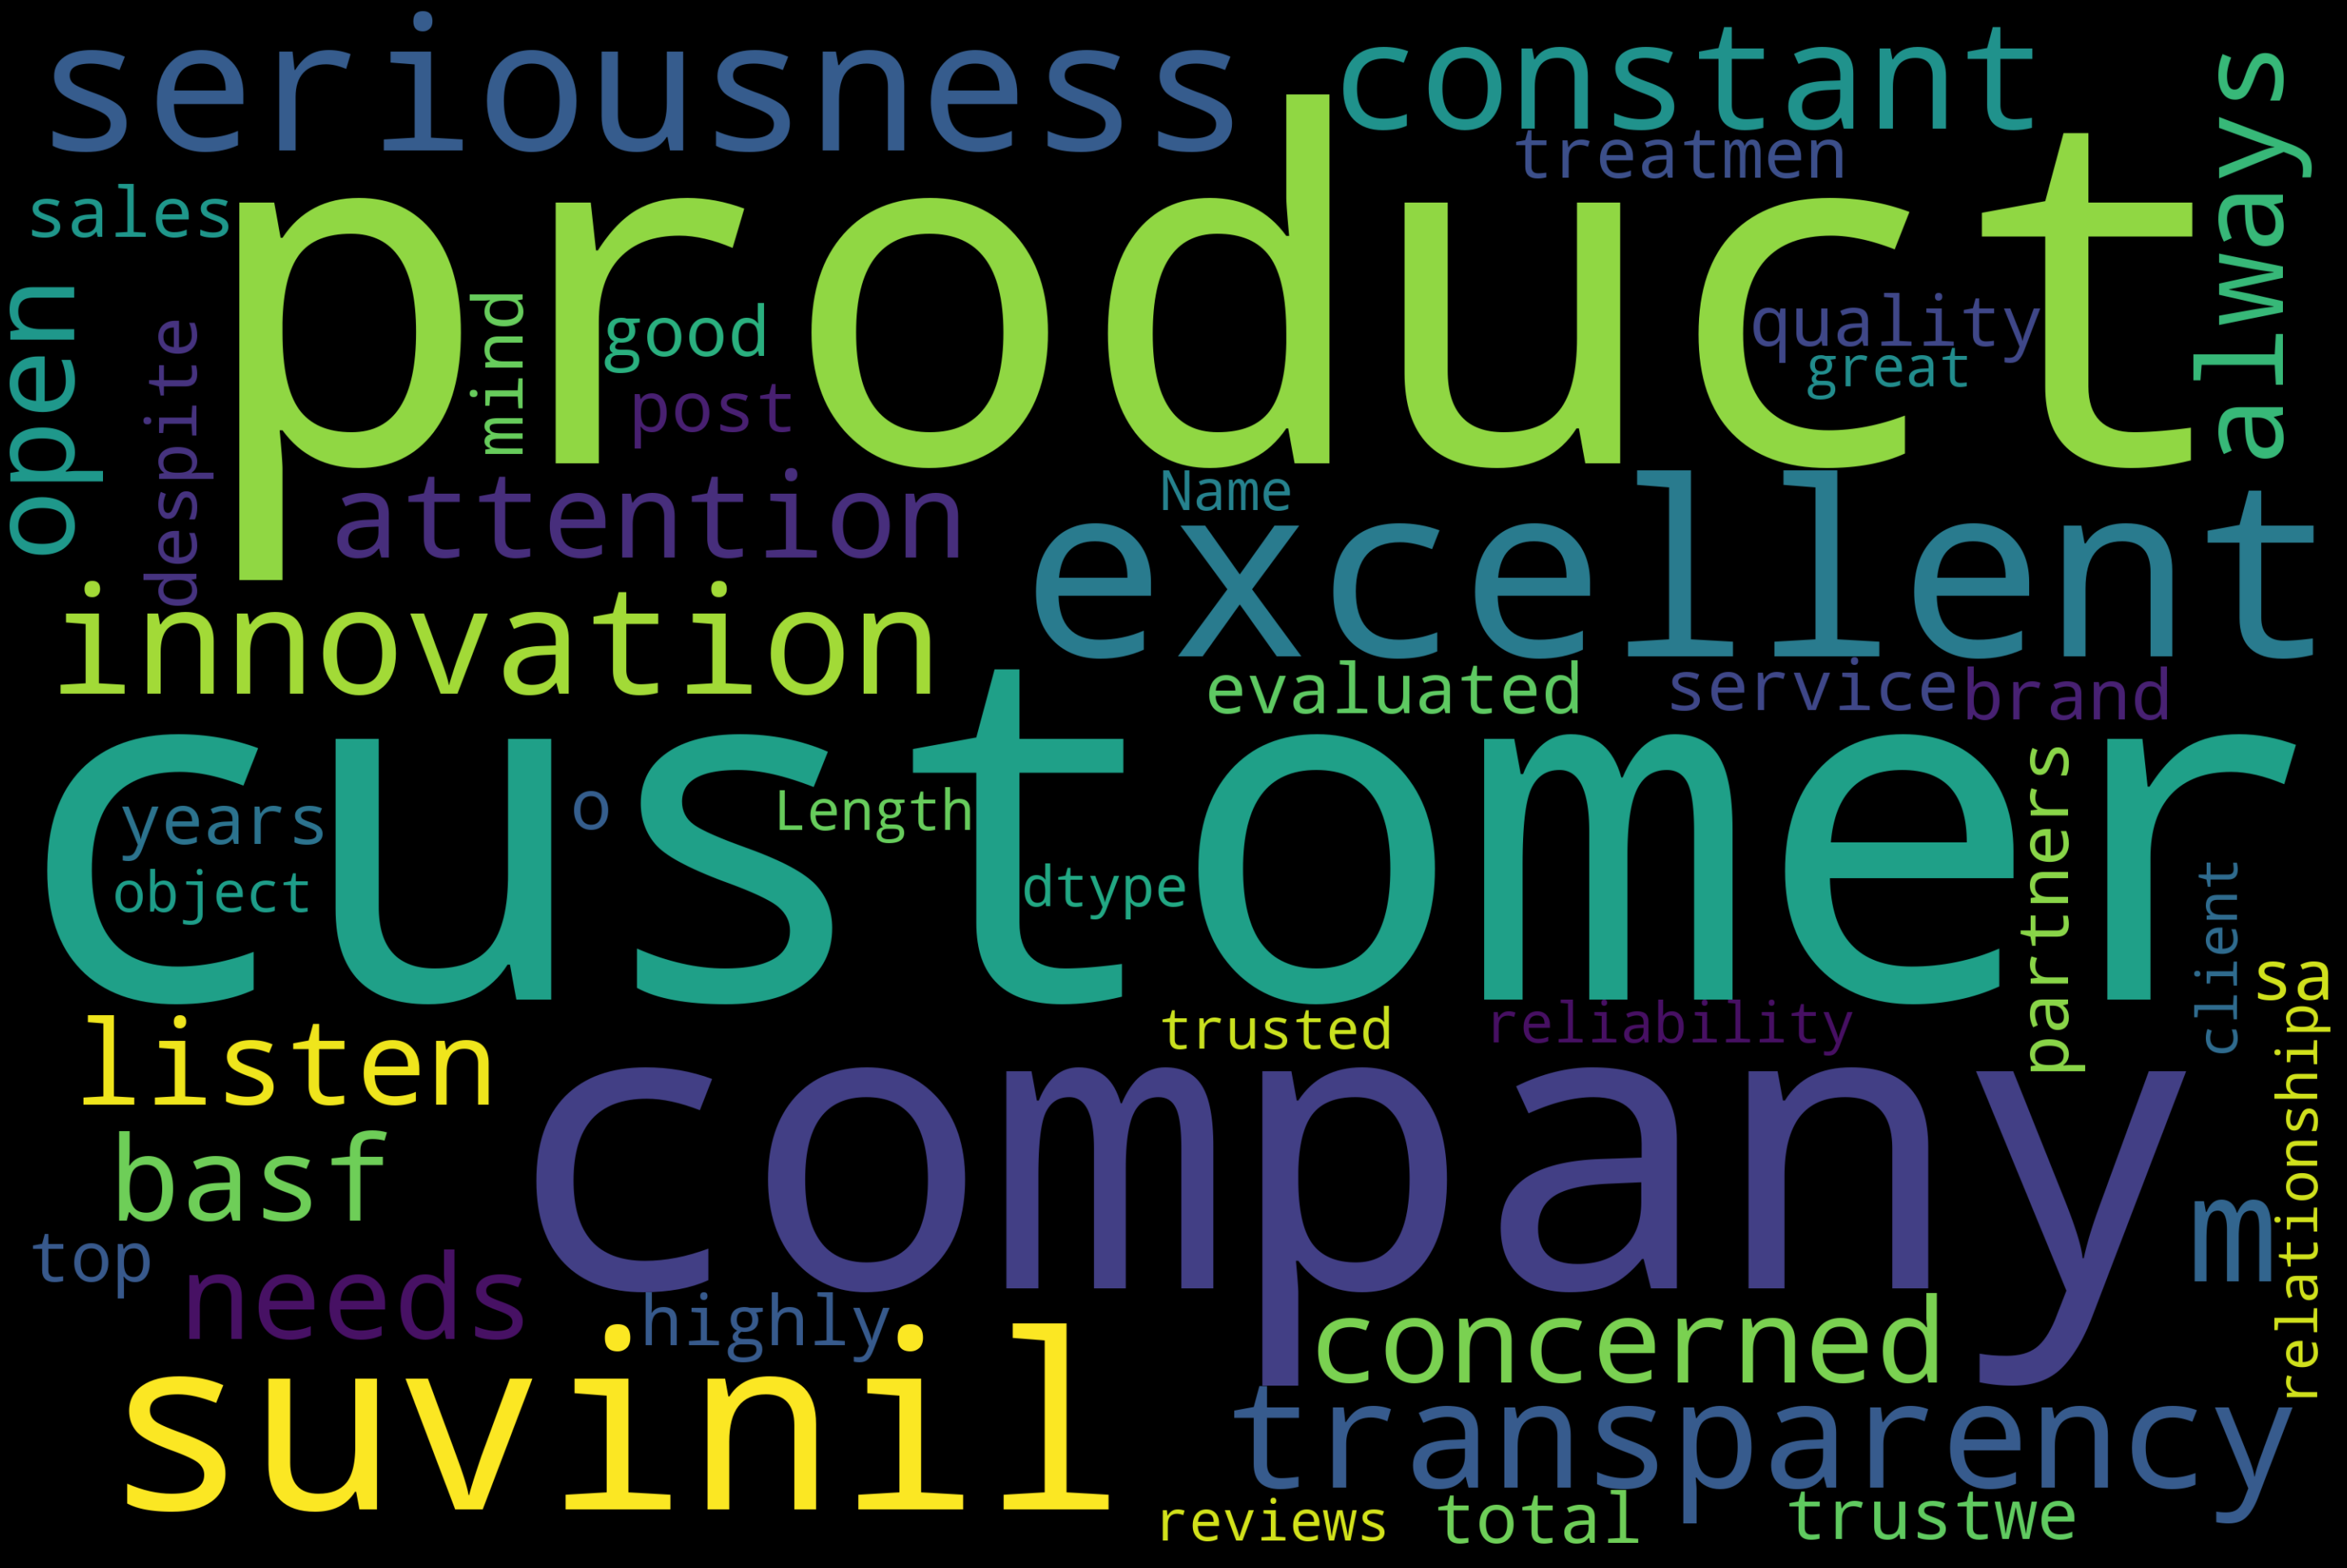

In [37]:
text = positive_review["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

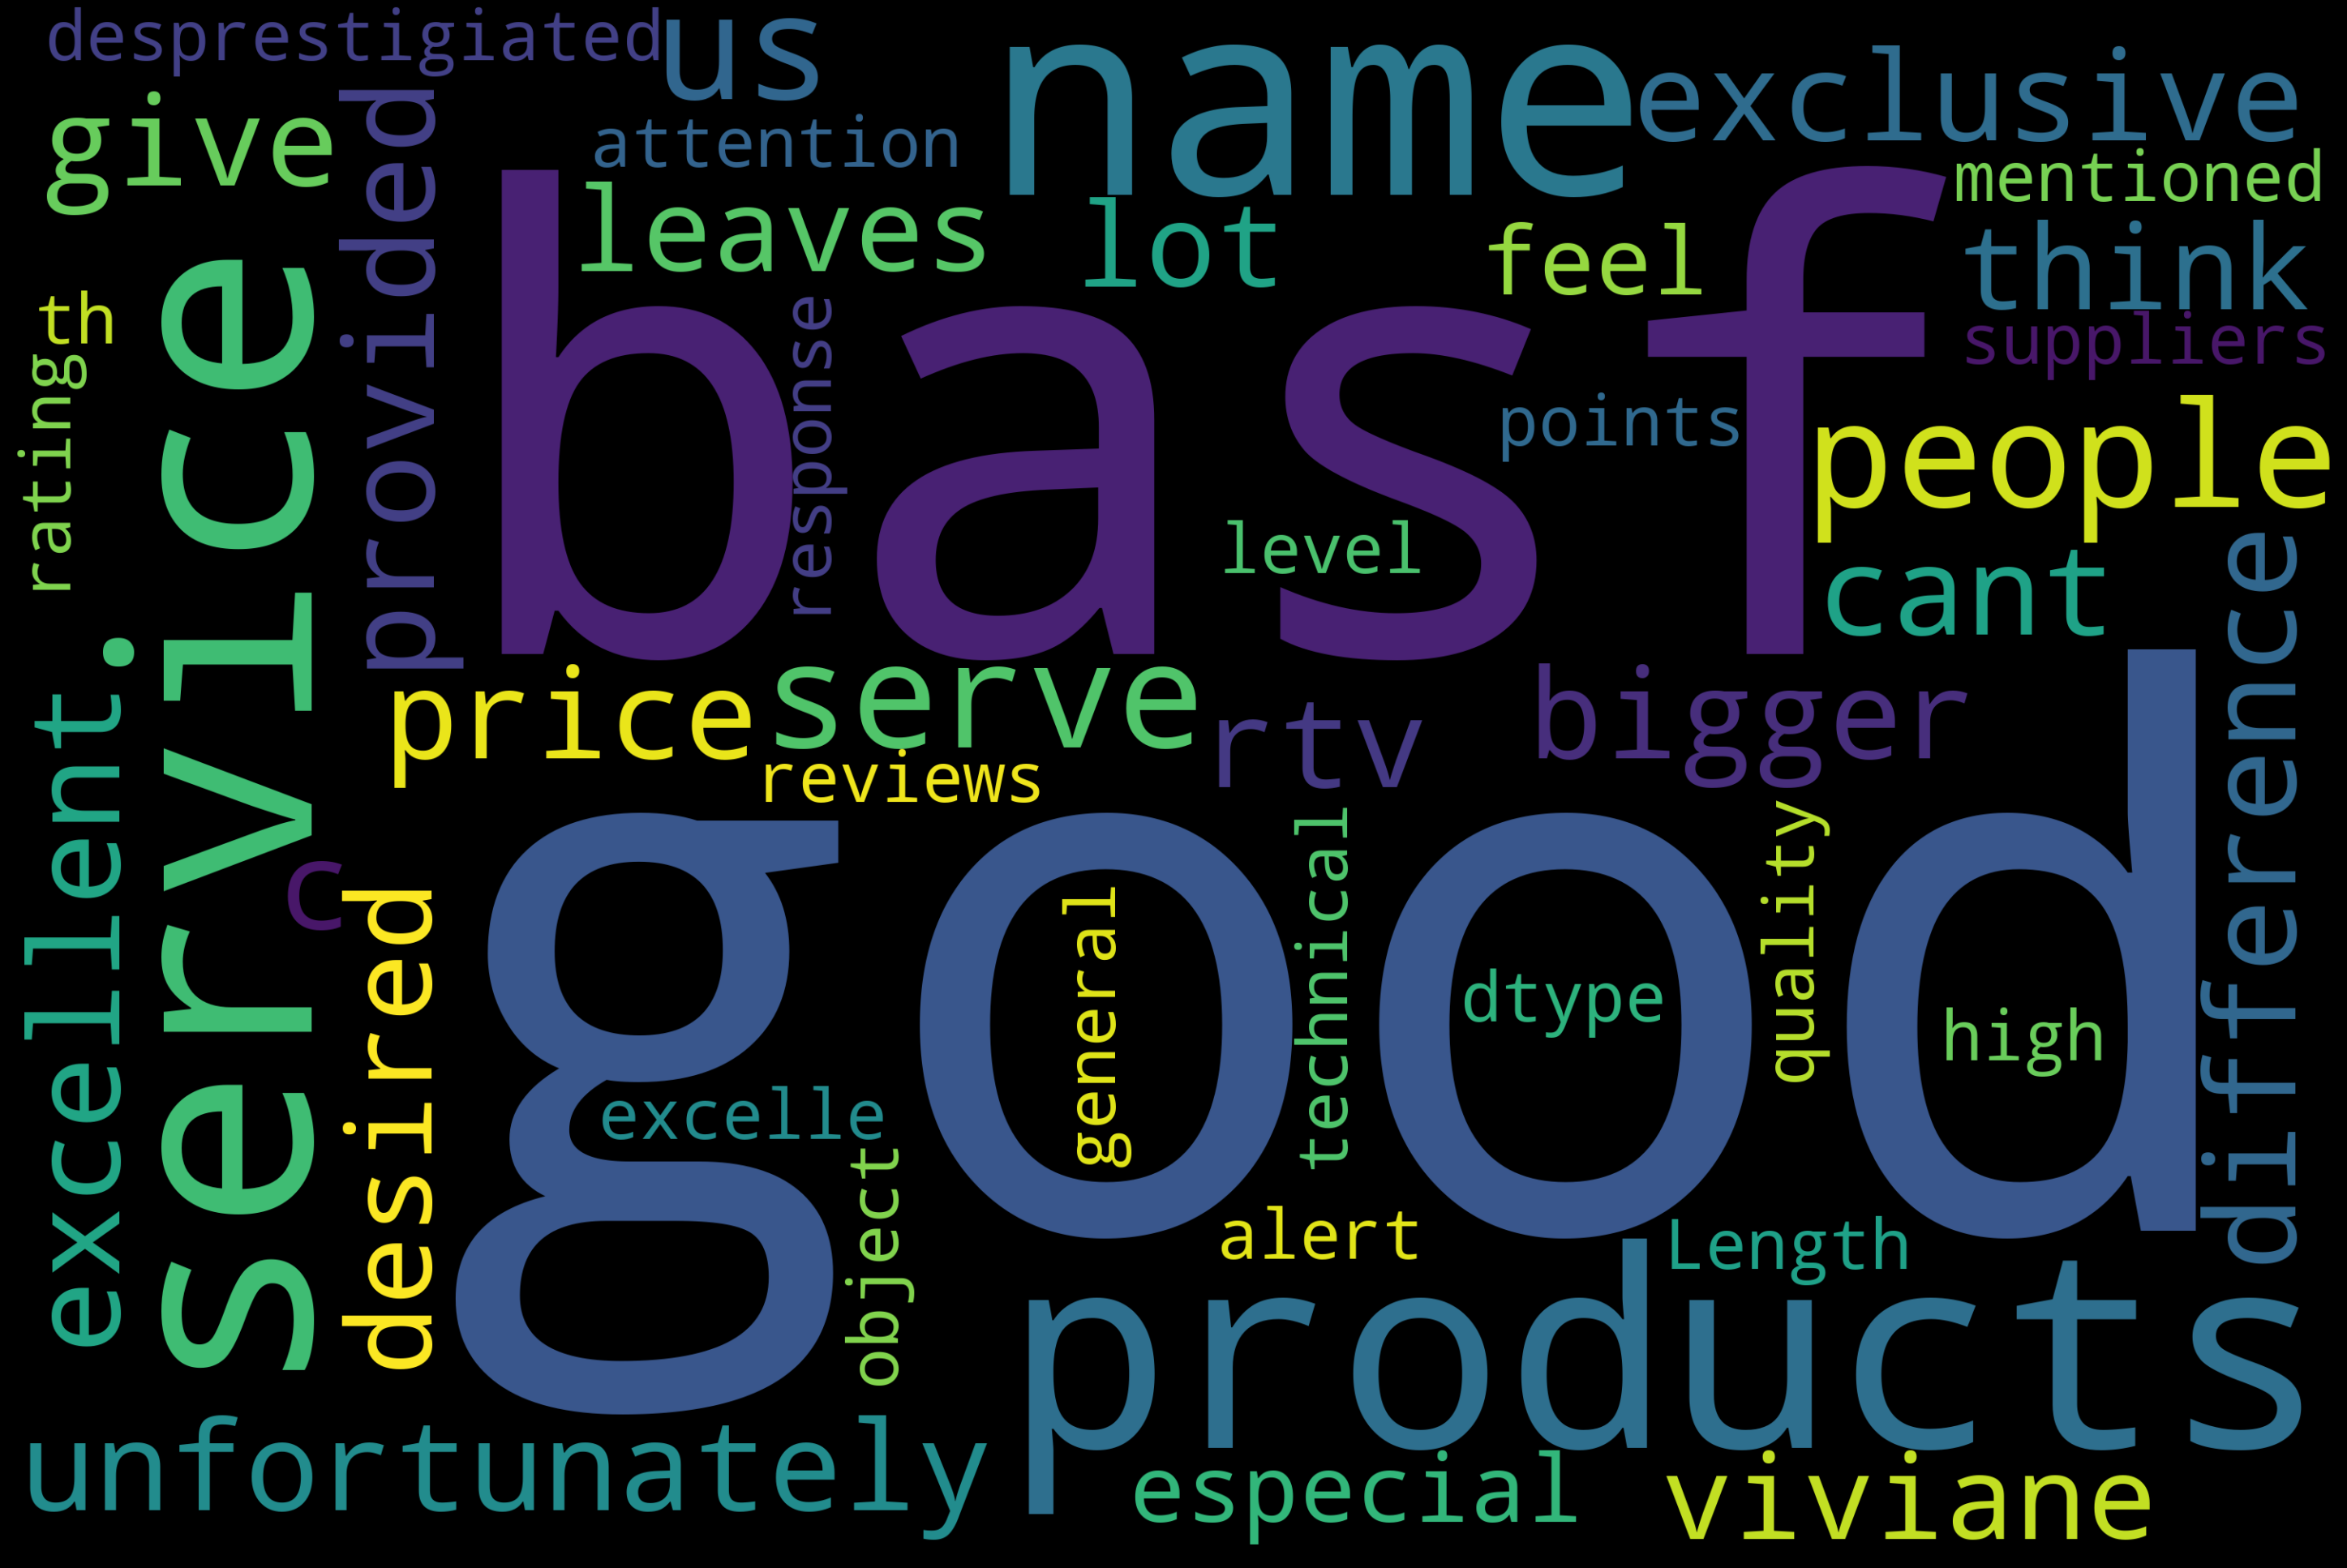

In [38]:
text = neutral_review["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

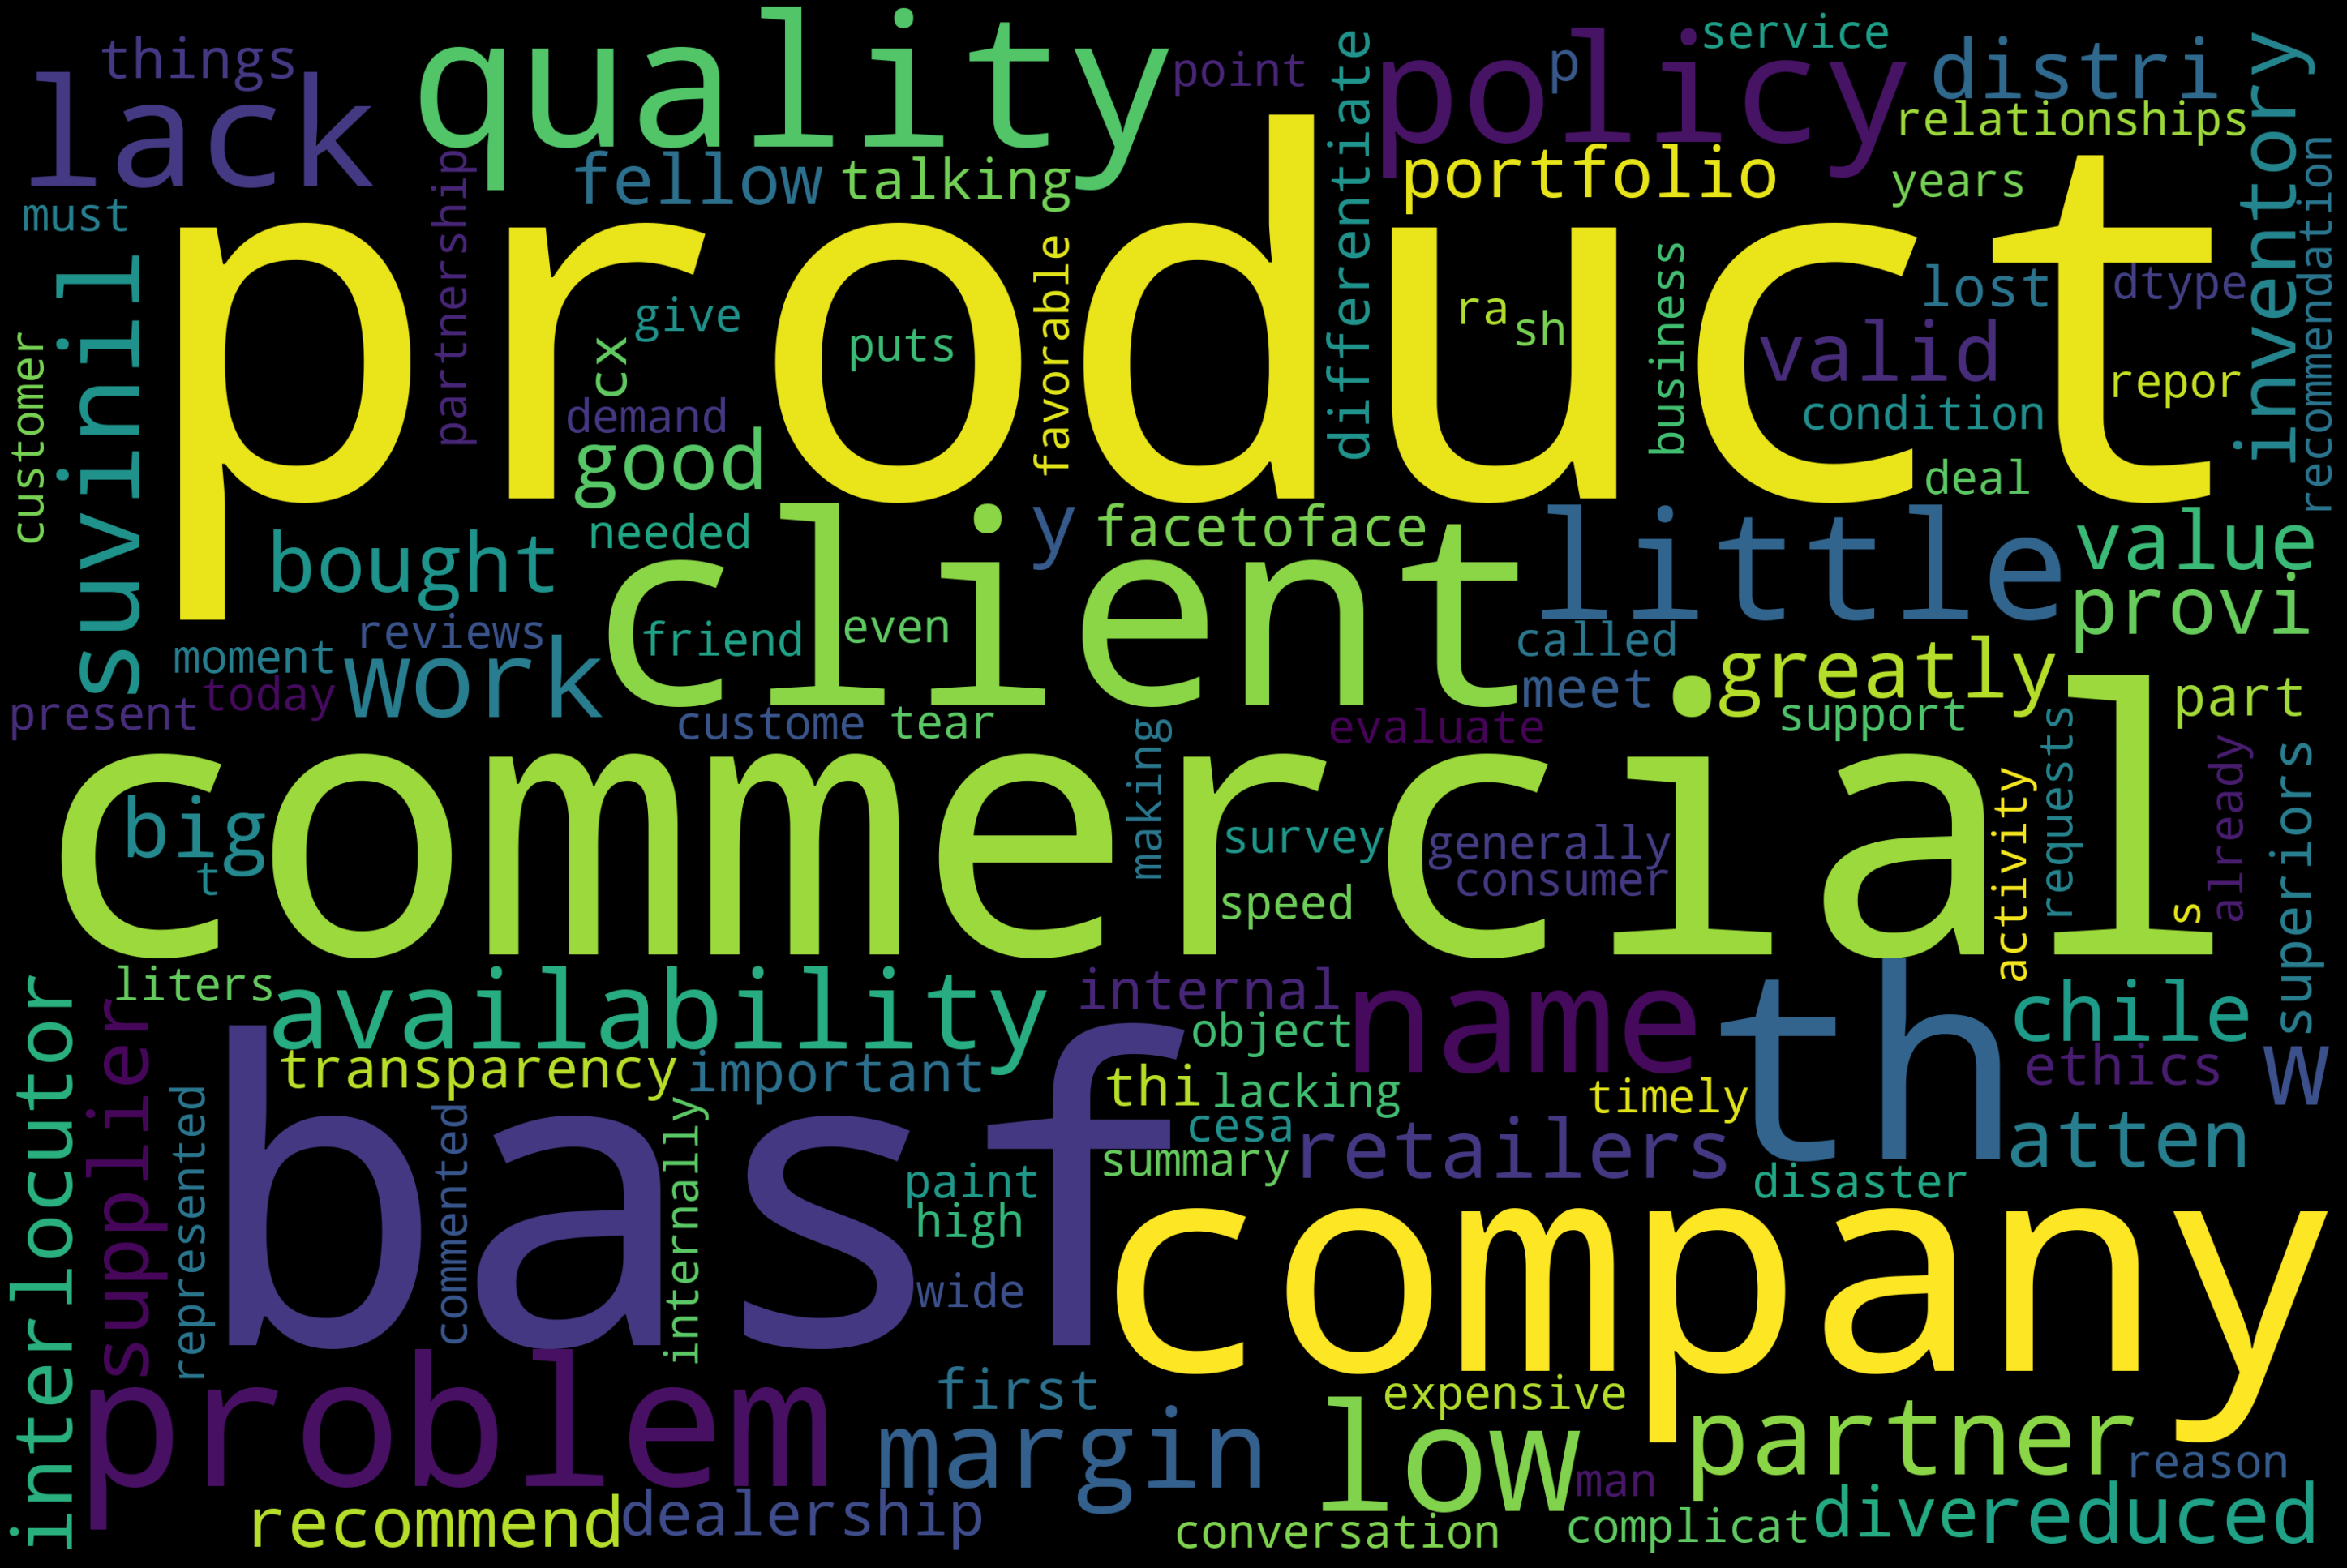

In [39]:
text = negative_review["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Extracting Features from Reviews
Before building the model for doing sentiment analysis, it is required to convert the review texts into vector formation as computer cannot understand words and their sentiment. After that TF-TDF method to convert the texts.

## Encoding target variable-sentiment

In [40]:
# calling the label encoder function
le = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
df['Sentiment']= le.fit_transform(df['Sentiment']) 

df['Sentiment'].unique() 

array([1, 2, 0])

In [ ]:
df['Sentiment'].value_counts()

In [41]:
#Extracting 'reviews' for processing
review_features = df.copy()
review_features = review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  basf has good products and the people serve us...
1  unfortunately i cant give bigger name because ...
2  seriousness transparency innovation constant m...
3  attention to customer needs customer concerned...
4  the difference in price between an exclusive c...

## TFIDF(Term Frequency — Inverse Document Frequency)
TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents, we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

Here we are splitting as bigram (two words) and consider their combined weight.Also we are taking only the top 5000 words from the reviews.

In [42]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (2,2))
# TF-IDF feature matrix
X = tfidf_vectorizer.fit_transform(review_features['reviews'])
X.shape

(327, 5000)

We considered 5000 words, we can confirm that we have 5000 columns from the shape.

In [43]:
#Getting the target variable(encoded)
y = df['Sentiment']
y.shape

(327,)

## Imbalance feature target - Synthetic Minority Oversampling Technique (SMOTE)
In our dataset, there are a lot of positive sentiments compared to negative and neutral, which makes our dataset imbalanced. In order to work for imbalance dataset, SMOTE technique is used to balance out the imbalanced dataset problem. It's aims is to balance class distribution by randomly increasing minority class examples by replicating them.

SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [44]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_resampled)}')

Original dataset shape : Counter({2: 191, 1: 101, 0: 35})
Resampled dataset shape Counter({1: 191, 2: 191, 0: 191})


Thus, the resampled data has equally distributed classes/labels.

## Model Building

## Train - Test Split
Using train test split function we are splitting the dataset into 80:20 ratio for train and test set respectively

In [45]:
## Splitting the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state=0)

In [46]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Purples):
    """
    This function prints and plots the confusion matrix.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
#creating the objects
logreg = LogisticRegression(random_state=0)
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
svc = SVC()
nb = BernoulliNB()
rf = RandomForestClassifier()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2:'KNN', 3:'SVC', 4:'Naive Bayes', 5: 'Random Forest'}
cv_models = [logreg, dt, knn, svc, nb, rf]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv = 10, scoring = 'accuracy').mean()))

Logistic Regression Test Accuracy: 0.5841856060606061
Decision Tree Test Accuracy: 0.5050189393939395
KNN Test Accuracy: 0.4857954545454545
SVC Test Accuracy: 0.5841856060606061
Naive Bayes Test Accuracy: 0.5748106060606061
Random Forest Test Accuracy: 0.575094696969697


In [48]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state = 0), param_grid, cv = 5, verbose = 0,n_jobs = -1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:", best_model.score(X_test,y_test))

LogisticRegression(C=339.3221771895323, random_state=0)
The mean accuracy of the model is: 0.8608695652173913


From the selected parameters of C and random_state

In [49]:
logreg = LogisticRegression(C = 6866.498, random_state = 0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.86


## Classification metrics
Since the accuracy turns out to be 86%, for classification problems, confusion matrix and f1 score is required than accuracy alone.

Confusion matrix, without normalization


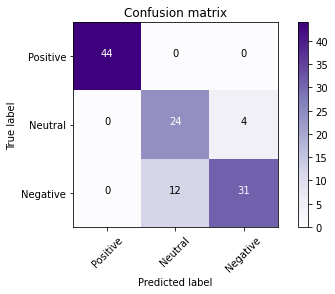

In [50]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Positive','Neutral','Negative'])

The diagonal elements (44+24+31), they are correctly predicted records and rest are incorrectly classified by the algorithm.

In [51]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        44
           1       0.67      0.86      0.75        28
           2       0.89      0.72      0.79        43

    accuracy                           0.86       115
   macro avg       0.85      0.86      0.85       115
weighted avg       0.88      0.86      0.86       115



## ROC-AUC curve
This is a very important curve where we decide on which threshold to setup based upon the objective criteria. Here we plotted ROC for different classes which can help us understand which class was classified better. Also we plot micro and macro averages on the roc curve.

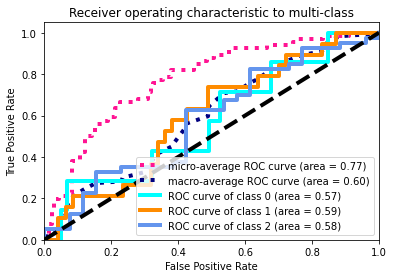

In [52]:
#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel ='linear', probability = True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw = 4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc = "lower right")
plt.show()

Insights:

The ROC curve for classes, class 2 and 0 have been classified pretty well a their area under the curve is high. We can chose any threshold between 0.6-0.8 to get the optimal number of TPR and FPR
Coming to micro and macro average, micro average preforms really well and macro average shows a not very good score If you don't understand what micro and macro average is, just remember the following 'A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, micro-average is preferable if you suspect there might be class imbalance'

## Conclusion
Classifying all the sentiment classes starting from splitting the sentiments based on overall score,text cleaning, customize the stopwords list based on requirement and finally handling imbalance with SMOTE. Here are few insights from the notebook.